# Action Space analysis for AWS DeepRacer
This notebook has been built for the [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 
provided by  the [AWS DeepRacer Community](http://join.deepracing.io).

## Usage
Copy this Notebook to "work" folder in your allready installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git)

**This notebook isn't complete.**
If you find some bugs, have problems with some tracks or something else
please report to @Kire in [AWS Machine Learning Community](https://aws-ml-community.slack.com) on #Slack

## Contributions
As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them
to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Requirements
Installed [AWS DeepRacer-Analysis](https://github.com/aws-deepracer-community/deepracer-analysis.git) 

## Credits
I would like to thank [the AWS DeepRacer Community](http://join.deepracing.io)

# Log Analysis

Let's get to it.

## Imports

Run the imports block below:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from deepracer.tracks import TrackIO, Track
from deepracer.logs import \
    SimulationLogsIO as slio, \
    PlottingUtils as pu,\
    AnalysisUtils as au   #, \

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

## Load waypoints for the track you want to run analysis on

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [2]:
tu = TrackIO()

for f in tu.get_tracks():
    print(f)

reinvent_base.npy


Take the name from results above and paste below to load the key elements of the track and view the outline of it.

Loaded 119 waypoints


<AxesSubplot:>

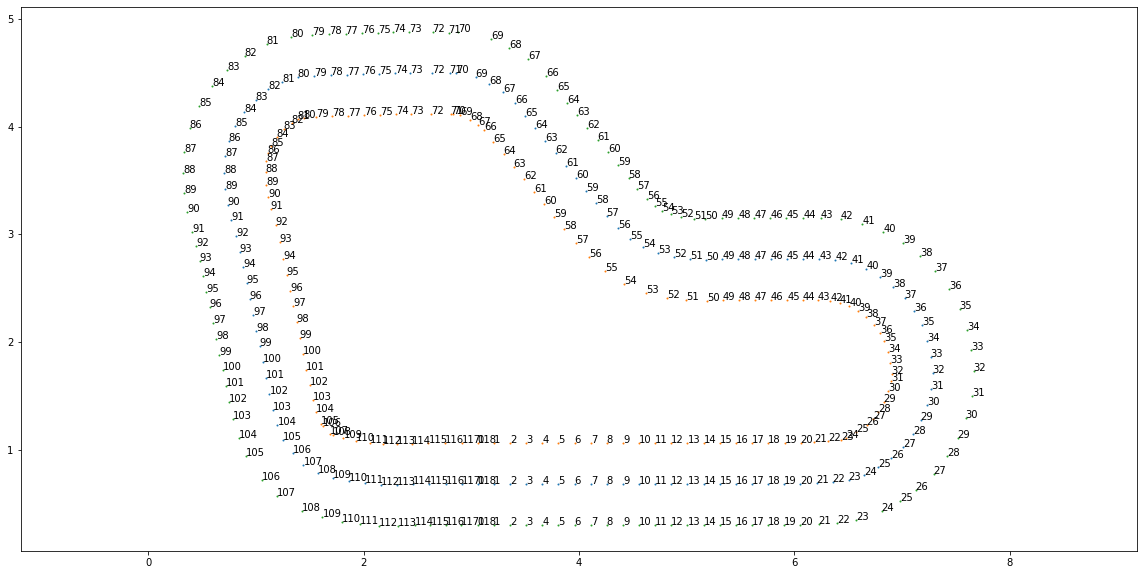

In [3]:
track: Track = tu.load_track("reinvent_base")
 
l_track = track.center_line
l_outer_border = track.outer_border
l_inner_border = track.inner_border

pu.plot_trackpoints(track)

## Get the logs

Depending on which way you are training your model, you will need a different way to load the data.

**AWS DeepRacer Console**
The logs are being stored in CloudWatch, in group `/aws/robomaker/SimulationJobs`. You will be using boto3 to download them based on the training ID (stream name prefix). If you wish to bulk export the logs from Amazon Cloudwatch to Amazon S3 :: https://docs.aws.amazon.com/AmazonCloudWatch/latest/logs/S3ExportTasks.html

**DeepRacer for Dummies/ARCC local training**
Those two setups come with a container that runs Jupyter Notebook (as you noticed if you're using one of them and reading this text). Logs are stored in `/logs/` and you just need to point at the latest file to see the current training. The logs are split for long running training if they exceed 500 MB. The log loading method has been extended to support that.

**Chris Rhodes' repo**
Chris repo doesn't come with logs storage out of the box. I would normally run `docker logs dr > /path/to/logfile` and then load the file.

Below I have prepared a section for each case. In each case you can analyse the logs as the training is being run, just in case of the Console you may need to force downloading of the logs as the `cw.download_log` method has a protection against needless downloads.

Select your preferred way to get the logs below and you can get rid of the rest.

In [227]:
# AWS DeepRacer Console
# fname = 'OldIsGoldv3.log'
# fname = 'MinimalTimev2.log'
# fname = 'SimpleTimeEfficient.log'
# fname = 'OldIsGoldv2.log'
# fname = 'SimpleTimeEfficientv2.log'
# fname = 'SelfMadev2.log'
# fname = 'SimpleTimeEfficientv2-enhancement.log'
fname = 'OptimalRacingLinev2.log'
# fname = 'oldIsGoldv4.log'
# fname = 'MinimalTimev3.log'


## Load the trace training log

Now that the data is downloaded, we need to load it into memory. We will first read it from file and then convert to data frames in Pandas. [Pandas](https://pandas.pydata.org/) is a Python library for handling and analysing large amounts of data series. Remember this name, you may want to learn more about how to use it to get more information that you would like to get from the logs. Examples below are hardly scratching the surface.

One important information to enter is the setting of your Episodes per iteration hyperparameter. This is used to group the episodes into iterations. This information is valuable when later looking at graphs showing how the training progresses per iteration. You can use it to detect which iteration gave you better outcomes and, if in local training, you could move to that iteration's outcome for submissions in the AWS DeepRacer League or  for continuing the training.

The log files you have just gathered above have lines like this one:
```
SIM_TRACE_LOG:799,111,1.7594,4.4353,3.0875,-0.26,2.50,2,1.0000,False,True,71.5802,49,17.67,1555554451.1110387
```
This is all that matters for us. The first two are some tests I believe and when loading they get skipped, then each next line has the following fields:
* episode number
* step number
* x coordinate
* y coordinate
* yaw of the car (where the car is heading)
* decision about turning (turn value from your action space)
* decision about throttle (speed value from your action space)
* decision index (value from your action space)
* reward value
* is the car going backwards
* are all wheels on track?
* progress in the lap
* closest waypoint
* track length
* timestamp

`la.load_data` and then `la.convert_to_pandas` read it and prepare for your usage. Sorting the values may not be needed, but I have experienced under some circumstances that the log lines were not ordered properly.

In [253]:
EPISODES_PER_ITERATION = 20 #  Set to value of your hyperparameter in training

data = slio.load_data(fname)
df = slio.convert_to_pandas(data, episodes_per_iteration=EPISODES_PER_ITERATION)

df = df.sort_values(['episode', 'steps'])
# personally I think normalizing can mask too high rewards so I am commenting it out,
# but you might want it.
# slio.normalize_rewards(df)

#Uncomment the line of code below to evaluate a different reward function
#nr.new_reward(df, l_center_line, 'reward.reward_sample') #, verbose=True)

new reward not found, using reward as its values
Number of episodes =  570
Number of iterations =  29


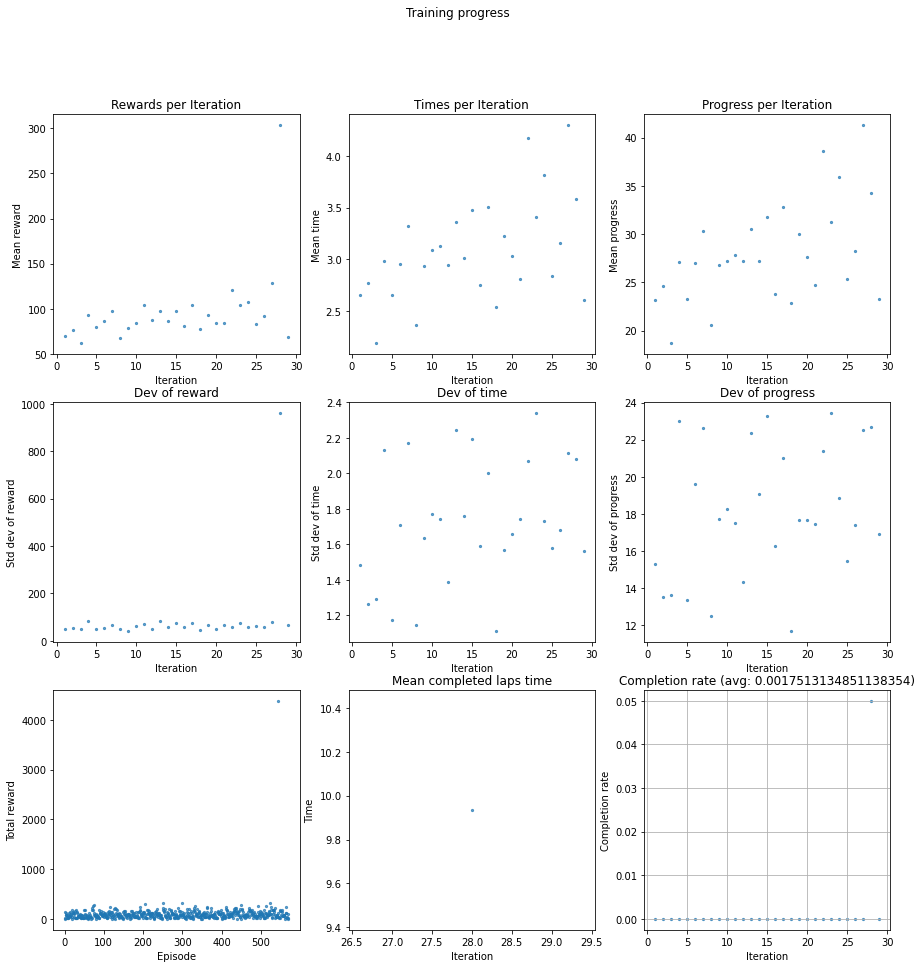

<Figure size 432x288 with 0 Axes>

In [254]:
simulation_agg = au.simulation_agg(df)
au.analyze_training_progress(simulation_agg, title='Training progress')

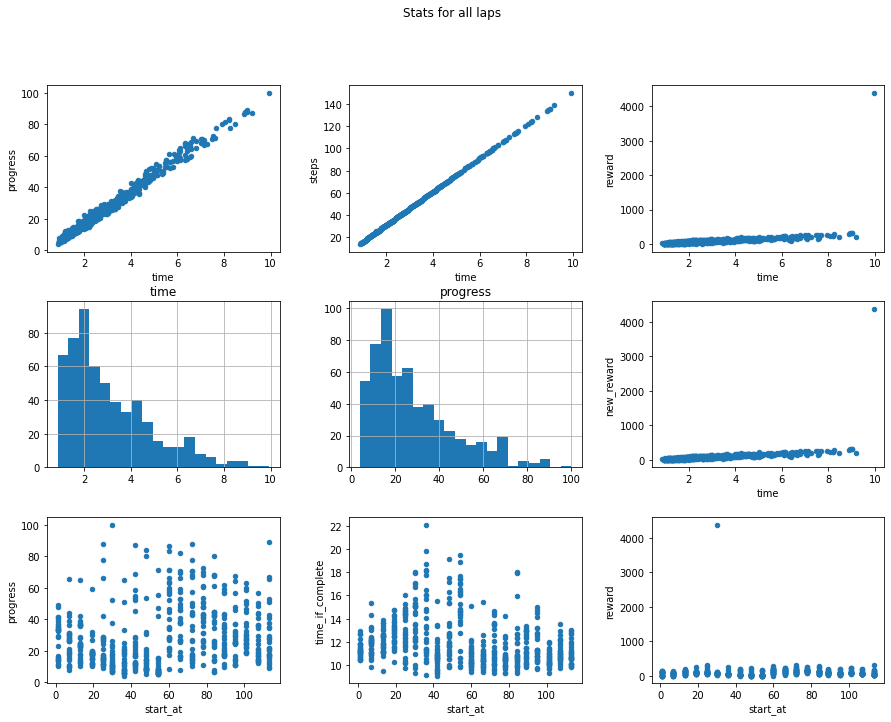

<Figure size 432x288 with 0 Axes>

In [255]:
au.scatter_aggregates(simulation_agg, 'Stats for all laps')

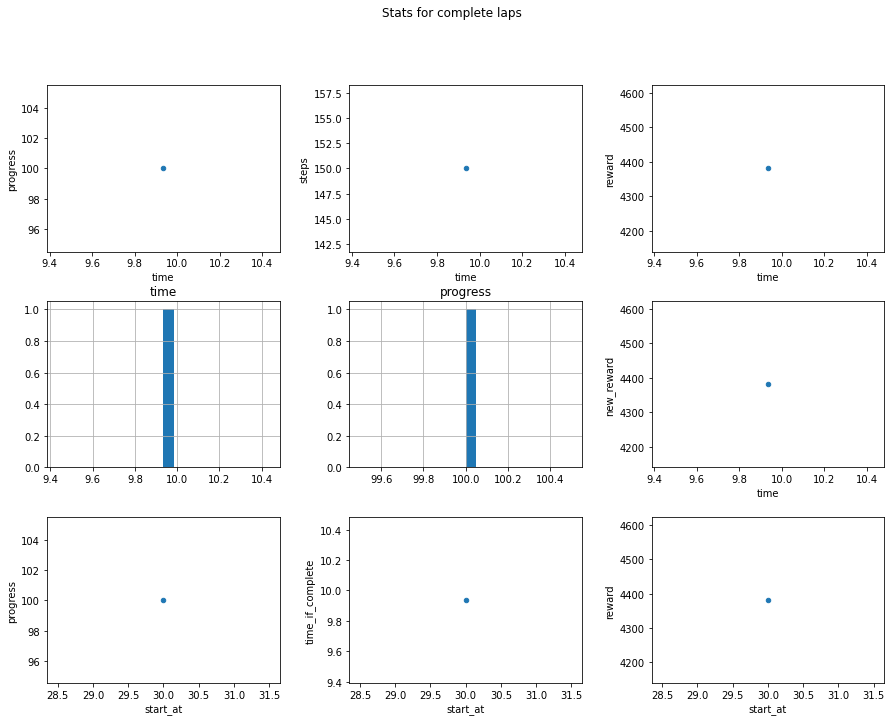

<Figure size 432x288 with 0 Axes>

In [256]:
complete_ones = simulation_agg[simulation_agg['progress']==100]

if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, 'Stats for complete laps')
else:
    print('No complete laps yet.')

In [257]:
# View five best rewarded in completed laps (according to new_reward if you are using it)
complete_ones.nlargest(5, 'reward')

,iteration,episode,steps,start_at,progress,time,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
545,28,545,150,30,100.0,9.935,4380.2934,1.874667,4380.2934,9.935,4380.2934,5th,1


In [258]:
# View five most progressed episodes
print(fname)
a = simulation_agg.nlargest(50, 'progress')
a.sort_values(by='progress')
a

OptimalRacingLinev2.log


,iteration,episode,steps,start_at,progress,time,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
545,28,545,150,30,100.0000,9.935,4380.2934,1.874667,4380.2934,9.935000,4380.293400,5th,1
299,15,299,136,113,89.3780,9.007,314.1460,1.974265,314.1460,10.077424,351.480230,3rd,0
524,27,524,135,25,87.8072,8.921,321.2132,1.893333,321.2132,10.159759,365.816471,5th,0
252,13,252,136,72,87.5845,9.010,318.4238,1.888235,318.4238,10.287208,363.561817,3rd,0
127,7,127,139,42,86.9910,9.204,207.8300,1.879137,207.8300,10.580405,238.909772,2nd,0
450,23,450,134,60,86.4358,8.873,283.8698,1.909701,283.8698,10.265422,328.416929,4th,0
128,7,128,124,48,83.6828,8.202,222.5688,2.104839,222.5688,9.801297,265.967200,2nd,0
290,15,290,124,60,83.0739,8.197,224.3167,2.013710,224.3167,9.867118,270.020668,3rd,0
191,10,191,122,66,81.7840,8.059,232.7283,1.977869,232.7283,9.854006,284.564585,2nd,0
74,4,74,120,84,80.4368,7.930,271.2819,2.043333,271.2819,9.858672,337.260930,1st,0


In [259]:
# View information for a couple last episodes
simulation_agg.tail()

,iteration,episode,steps,start_at,progress,time,new_reward,speed,reward,time_if_complete,reward_if_complete,quintile,complete
566,29,566,19,36,8.5074,1.193,43.9216,2.084211,43.9216,14.023086,516.275243,5th,0
567,29,567,18,42,10.4258,1.131,11.8417,2.611111,11.8417,10.848088,113.580732,5th,0
568,29,568,29,48,17.0173,1.865,4.2708,1.910345,4.2708,10.959435,25.096813,5th,0
569,29,569,34,54,15.0411,2.199,15.3484,1.802941,15.3484,14.619941,102.043069,5th,0
570,29,570,43,60,27.0369,2.808,91.0226,2.218605,91.0226,10.385806,336.660638,5th,0


In [260]:
# Set maximum quantity of rows to view for a dataframe display - without that
# the view below will just hide some of the steps
pd.set_option('display.max_rows', 500)

# View all steps data for episode 10
df[df['episode']==545]

,iteration,episode,steps,x,y,yaw,steering_angle,speed,action,reward,done,on_track,progress,closest_waypoint,track_len,tstamp,episode_status,pause_duration,new_reward
25740,28,545,1,7.2579,1.4838,67.5156,23.6,1.4,13,0.0000,0,True,0.7890,30,17.71,2364.831,prepare,0.0,0.0000
25741,28,545,2,7.2580,1.4836,67.5077,23.6,1.4,13,4.2228,0,True,0.7883,30,17.71,2364.907,in_progress,0.0,4.2228
25742,28,545,3,7.2594,1.4916,67.9523,13.2,1.4,3,4.2226,0,True,0.8340,31,17.71,2364.969,in_progress,0.0,4.2226
25743,28,545,4,7.2625,1.5130,69.1555,23.6,1.4,13,4.2230,0,True,0.9551,31,17.71,2365.024,in_progress,0.0,4.2230
25744,28,545,5,7.2675,1.5499,71.1074,3.5,1.7,4,3.6765,0,True,1.1629,31,17.71,2365.098,in_progress,0.0,3.6765
25745,28,545,6,7.2717,1.6003,73.9856,3.5,1.7,4,3.6726,0,True,1.4510,31,17.71,2365.161,in_progress,0.0,3.6726
25746,28,545,7,7.2760,1.6653,77.0624,13.2,1.4,3,4.2168,0,True,1.8188,32,17.71,2365.224,in_progress,0.0,4.2168
25747,28,545,8,7.2755,1.7439,81.0924,13.4,3.1,5,2.2531,0,True,2.2696,32,17.71,2365.295,in_progress,0.0,2.2531
25748,28,545,9,7.2657,1.8390,86.3593,11.3,1.7,10,3.7009,0,True,2.8092,33,17.71,2365.367,in_progress,0.0,3.7009
25749,28,545,10,7.2498,1.9342,91.1051,13.2,1.4,3,4.2108,0,True,3.3560,33,17.71,2365.434,in_progress,0.0,4.2108


# Extract Action Space List from LOG file

In [261]:
# Extract Action Space List
dgr_norm = 1 # for degrees

if df['steering_angle'].max()<2: dgr_norm = 57.6923 # for radians

class act(object):
    def __init__(self, index=None, steer=None, throttle=None, rel_thr=None, color=([0,0,0])):
        self.index = index
        self.steer = steer
        self.throttle = throttle # relative throttle, max = 1
        self.rel_thr = rel_thr
        self.color = color

maxThrottle = df.speed.max()

AS = df[df['steps'] != 0].groupby(['action'], as_index=False)['steering_angle','speed'].median()
asl = [None] * AS.shape[0]
for i in range(0,AS.shape[0]):
    j = AS.action[i].astype(int)
    #asl[AS.action[i].astype(int)] = [AS.action[i].astype(int), round(AS.steer[i]*dgr_norm,2), round(AS.throttle[i],2)]
    asl[j] = act(j, round(AS.steering_angle[i]*dgr_norm,2), round(AS.speed[i],2))
    asl[j].rel_thr = AS.speed[i] / maxThrottle
    
    cr = 8*max(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
    cg = (0+6*(30-abs(asl[j].steer)))/255
    cb = -8*min(0,np.sign(asl[j].steer))*abs(asl[j].steer)/255
 
    asl[AS.action[i].astype(int)].color = ([cr,cg,cb])

asMaxY = maxThrottle + 1

#########################################################
# define some constants for track graphs
trkFrame = 50

trkPlotXmin = df.x.min() - trkFrame
trkPlotXmax = df.x.max() + trkFrame
trkPlotYmin = df.y.min() - trkFrame
trkPlotYmax = df.y.max() + trkFrame

trkPlotXmin = min(l_outer_border[:,0]) - trkFrame
trkPlotXmax = max(l_outer_border[:,0]) + trkFrame
trkPlotYmin = min(l_outer_border[:,1]) - trkFrame
trkPlotYmax = max(l_outer_border[:,1]) + trkFrame

trkSizeX = int(trkPlotXmax - trkPlotXmin)
trkSizeY = int(trkPlotYmax - trkPlotYmin)

trkShiftX = int(trkSizeX - trkPlotXmax)
trkShiftY = int(trkSizeY - trkPlotYmax)

#print(trkSizeX,trkSizeY,trkPlotYmin,trkPlotYmax)

##########################################################
# define some constants for Action Space graphs

asPlotXmin = round(df.steering_angle.min()*dgr_norm,2)
asPlotXmax = round(df.steering_angle.max()*dgr_norm,2)
asPlotYmin = round(df.speed.min(),2)
asPlotYmax = round(df.speed.max(),2)

#df.throttle.min()
#print(asPlotXmin,asPlotXmax,asPlotYmin,asPlotYmax)

###############################################################

print("Actions: \nindex\t\tsteering\tthrottle")
for obj in asl: 
    print( obj.index, obj.steer, obj.throttle, sep ='\t\t' ) 
    

Actions: 
index		steering	throttle
0		-4.4		1.5
1		-10.1		2.6
2		0.3		3.9
3		13.2		1.4
4		3.5		1.7
5		13.4		3.1
6		0.8		2.7
7		1.6		2.3
8		5.3		2.0
9		20.6		1.7
10		11.3		1.7
11		-6.8		1.8
12		-10.4		2.7
13		23.6		1.4
14		15.9		2.2
15		-11.5		3.3
16		5.8		1.4
17		-8.8		2.1
18		0.8		3.3
19		30.0		1.3
20		-30.0		1.3


## Function definitions

In [262]:
## Action Index Map
def plot_index_map(actSpaceList):
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(111)
    for obj in actSpaceList:
        N=100
        ax.set_title('Action Index Map')
        ax.axis([-35, 35, 0, asMaxY])
        ax.set(xlabel='Steering', ylabel='Speed',  xlim=(35,-35))
        scatter = ax.scatter((0.0 + obj.steer), (0.0 + obj.throttle),
                     color = obj.color,
                     s=1200 * obj.rel_thr,
                     alpha=0.85)
        ax.text((0.5 - obj.steer/70), (0.0 + obj.throttle/asMaxY), 
                obj.index,verticalalignment='center',
                horizontalalignment='center',
                transform=ax.transAxes, color ="w",
                fontsize=15)
    plt.show()

### Action space histograms

# 4 in 1 Histograms
def plot_4_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histograms for all episodes:') 
    fig, axs = plt.subplots(2, 2, sharex='col',figsize=(14, 10), sharey='row',  gridspec_kw={'hspace': 0, 'wspace': 0})  
    (ax1, ax2), (ax3, ax4) = axs
    ax3.hist2d(episode_data['steering_angle']*(dgr_norm), episode_data['speed'], bins=(63, 56),range=[[-31,31],[0,asMaxY]])
    ax3.set(xlabel='Steering', ylabel='Speed',  xlim=(31,-31)) 
    ax2 = plt.subplot(222, polar=True)
    ax2.set_theta_zero_location("N")
    ax2.hist2d(episode_data['steering_angle']*(dgr_norm/57.6923), episode_data['speed'], bins=(90, 23),range=[[-1.57,1.57],[0,asMaxY]])
        # ax2.hist(episode_data['action']*dgr_norm, bins=60)
    ax1.hist(episode_data['steering_angle']*dgr_norm, bins=60)
    ax4.hist(episode_data['speed'], bins=50, orientation="horizontal")# steer - throttle - actions
    for ax in fig.get_axes():
        ax.label_outer()
        
## Big Polar 2D Histogram
def plot_polar_hist(df, itr=-1,  E=-1):
    if itr > -1 :
        episode_data = df[df['iteration'] == itr]
        print('Histograms for iteration:',itr)
    else:
        if E > -1 :
            episode_data = df[df['episode'] == E]
            print('Histograms for episode:',E)
        else:
            episode_data = df[:]
            print('Histogram for all episodes:')           
    fig2 = plt.figure(1, figsize=(7, 7))    
    bx = fig2.add_subplot(111, polar=True)
    bx.set_theta_zero_location("N")
    bx.hist2d(episode_data['steering_angle']*(dgr_norm/57.6923), episode_data['speed'], bins=(90, 25),range=[[-1.57,1.57],[0,asMaxY]])
       
## Ploting steps in the episodes with red dots
def plot_episode_red(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        car_x2, car_y2 = x1 - 0.02, y1
        plt.plot([x1, car_x2], [y1, car_y2], 'r.')        
        
## Ploting steps in the episodes with dots of different colors and sizes
def plot_episode_color(df, E): #, center_line, inner_border, outer_border):
    fig = plt.figure(1, figsize=(trkSizeX/5, trkSizeY/5))
    ax = fig.add_subplot(211)
    ax.set_aspect(aspect=1)
    pu.print_border(ax, track, color="WhiteSmoke") # center_line, inner_border, outer_border) 
    episode_data = df[df['episode'] == E]
    for row in episode_data.iterrows():
        x1,y1,action,reward = row[1]['x'], row[1]['y'], row[1]['action'], row[1]['reward']
        actidx = int(action)
        action_color = asl[int(action)].color
        action_s = (asl[int(action)].throttle / maxThrottle)**2 * 50 # tune the size of the dots
        #print(action_color)
        #plt.scatter([x1, car_x2], [y1, car_y2], color=action_color, s=action_s, alpha=0.65)
        plt.scatter(x1, y1, color=action_color, s=action_s, alpha=0.75)

# Action Space Visualization

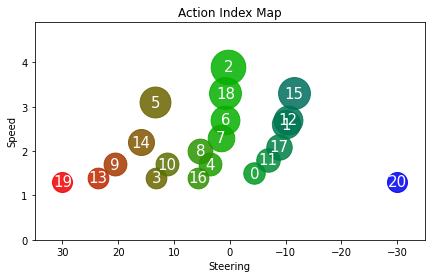

In [263]:
plot_index_map(asl)    

# Analysing data from all episodes

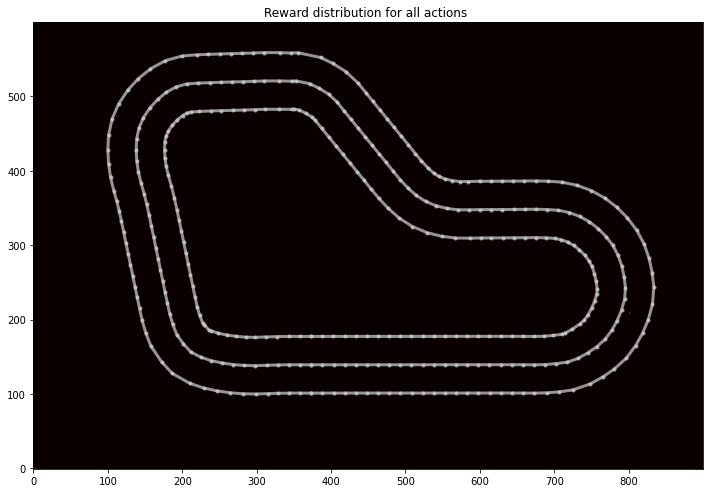

<Figure size 432x288 with 0 Axes>

In [264]:
tr_plot = pu.plot_track(df, track, value_field="reward") 

Histograms for all episodes:


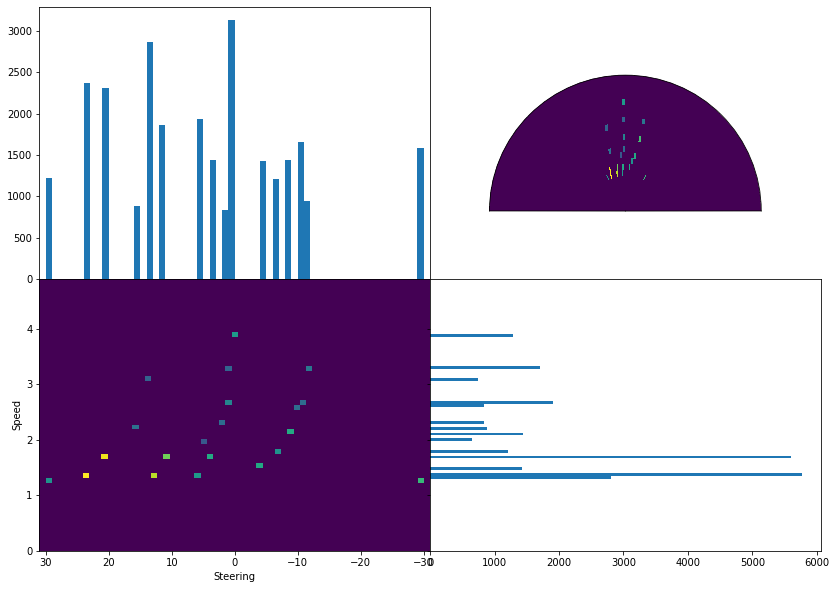

In [265]:
plot_4_hist(df)

Histogram for all episodes:


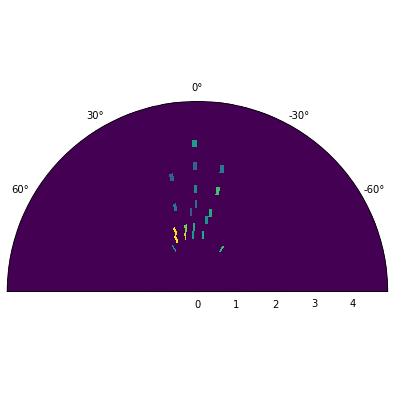

In [266]:
plot_polar_hist(df)



# Analyzing specific iteration





In [267]:
# Set iteration id
                      # iteration id
# itr=df['iteration'].max()-10     # last iteration

Iteration: 3


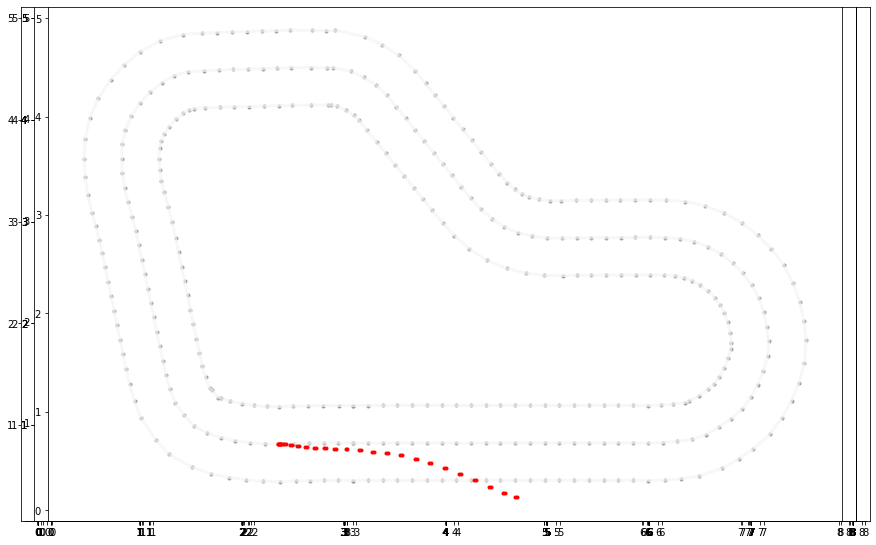

In [268]:
itr = 3
for i in range((itr-1)*EPISODES_PER_ITERATION, (itr)*EPISODES_PER_ITERATION):
    plot_episode_red(df,i) #,l_inner_border, l_inner_border, l_outer_border)
print('Iteration:',itr)    

Histograms for iteration: 3


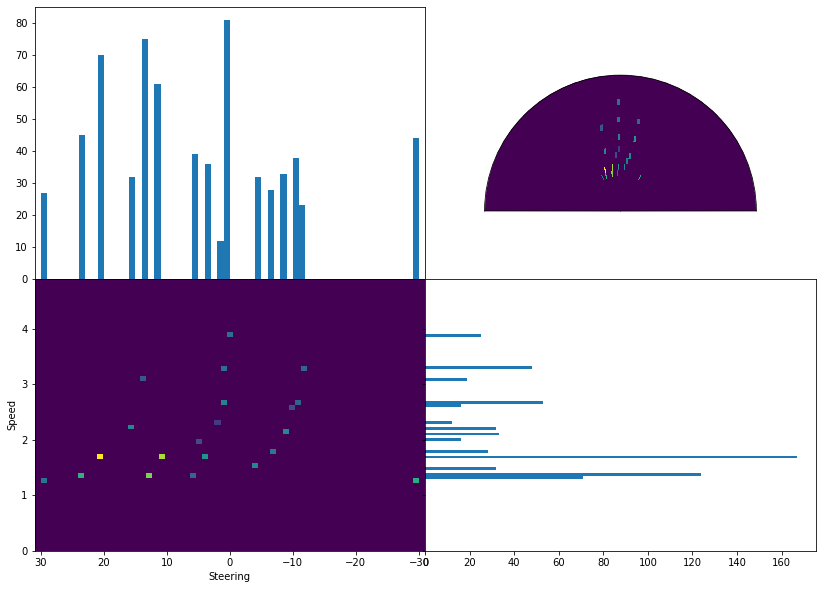

In [269]:
#plot_episode_as_hist(df, itr=25)  # specific iteration
plot_4_hist(df, itr)  # last iteration

Histograms for iteration: 3


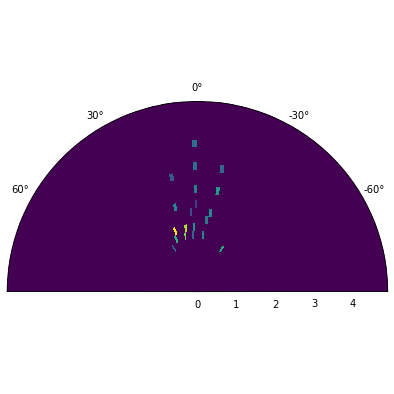

In [270]:
plot_polar_hist(df, itr)



# Analyzing specific episode



In [271]:
### choose episode id
EPZ = 140

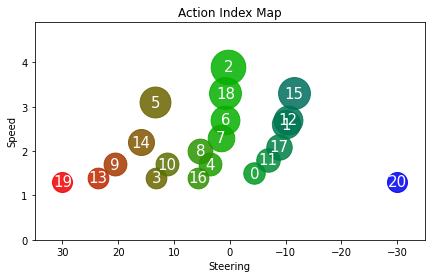

In [272]:
# Plot Index Map to understand graph
plot_index_map(asl)

Every dot is one step. Dot size is proportional to the throttle
Colors: Green = Straight, Red = Steering Left, Blue = Steering Right


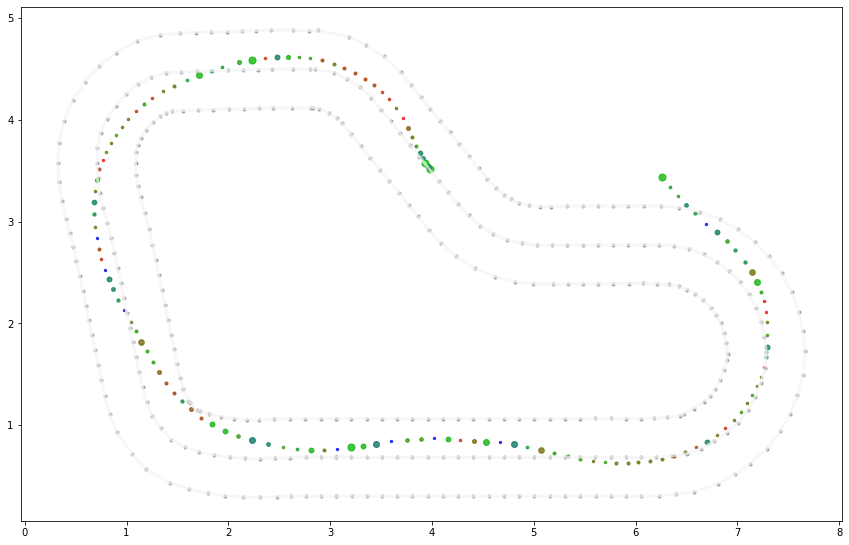

In [273]:
print("Every dot is one step. Dot size is proportional to the throttle")
print("Colors: Green = Straight, Red = Steering Left, Blue = Steering Right")
plot_episode_color(df,450) #, l_inner_border, l_inner_border, l_outer_border) # arbitrary episode

Histograms for episode: 140


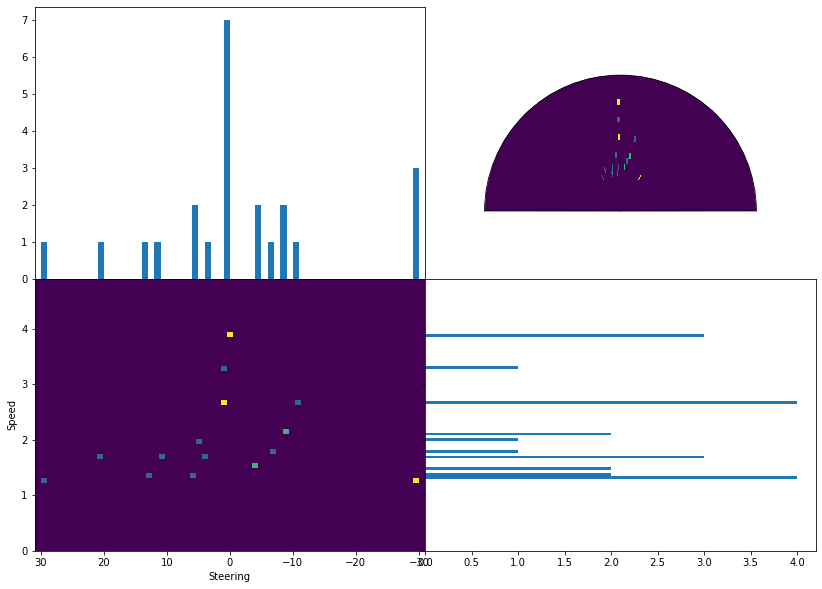

In [274]:
plot_4_hist(df, E = EPZ)

Histograms for episode: 140


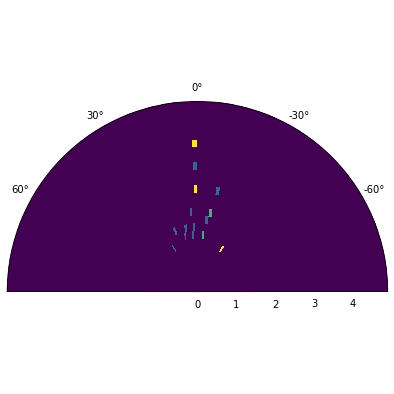

In [275]:
plot_polar_hist(df, E = EPZ)

<AxesSubplot:xlabel='closest_waypoint'>

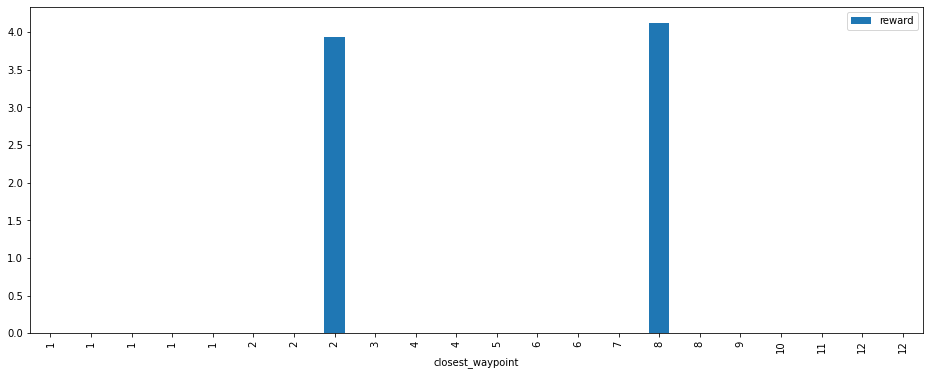

In [276]:
#This shows a histogram of actions per waypoint. Will let you spot potentially problematic places
episode = df[df['episode']==EPZ]
episode[:-1].plot.bar(x='closest_waypoint', y='reward',figsize=(16, 6))

# Analyzing Actions
## You can analyze all actions or only set of actions with indexes defined in setActions



 Heatmap for action with index 0: steering: -4.4, throttle: 1.5


<Figure size 432x288 with 0 Axes>

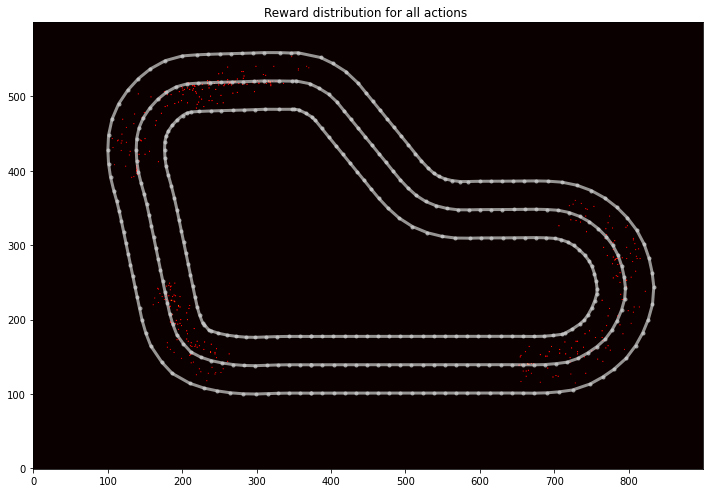

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 1: steering: -10.1, throttle: 2.6


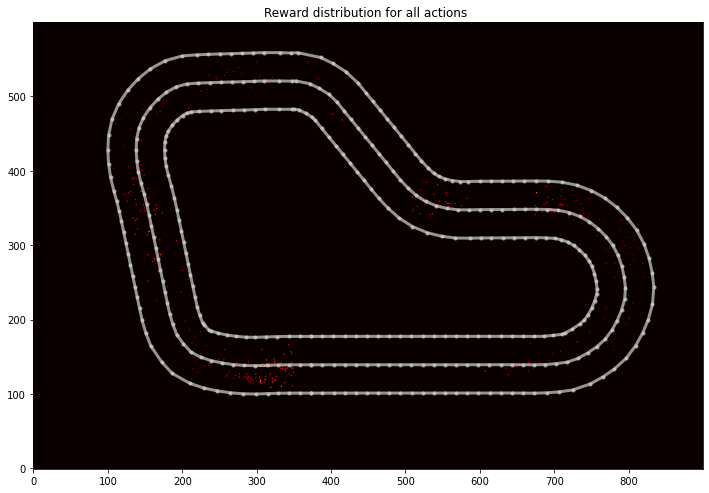

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 2: steering: 0.3, throttle: 3.9


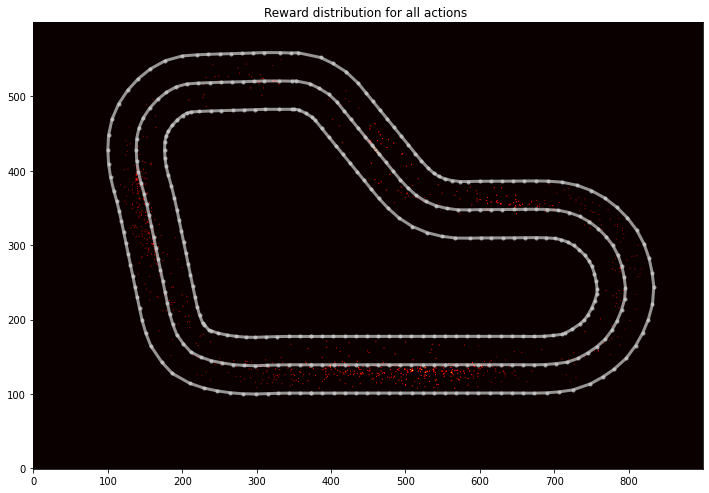

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 3: steering: 13.2, throttle: 1.4


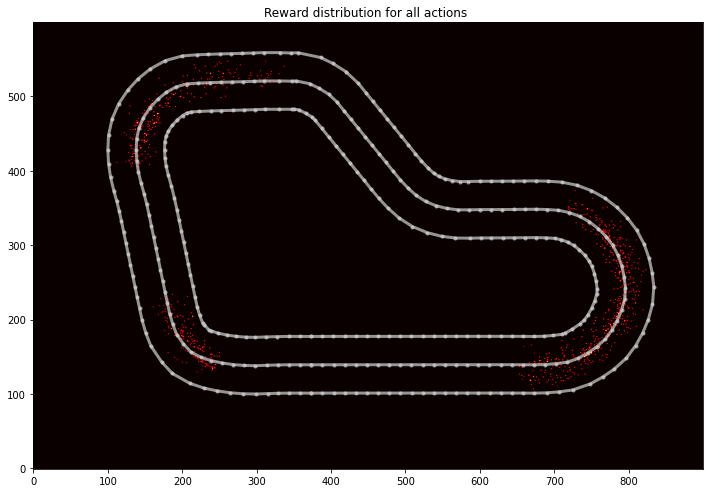

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 4: steering: 3.5, throttle: 1.7


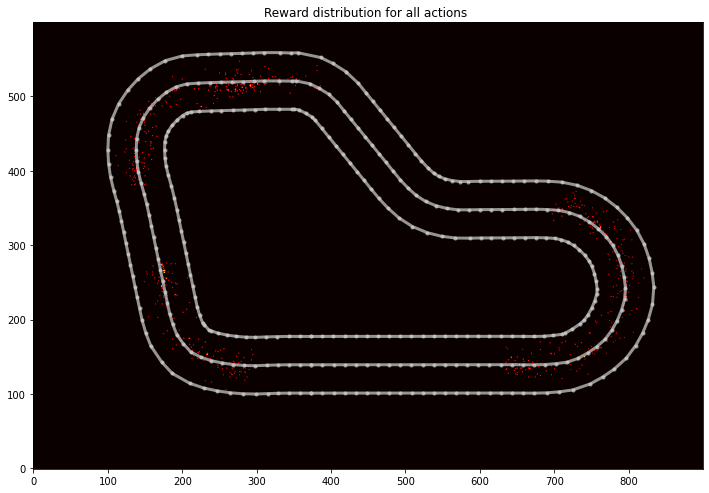

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 5: steering: 13.4, throttle: 3.1


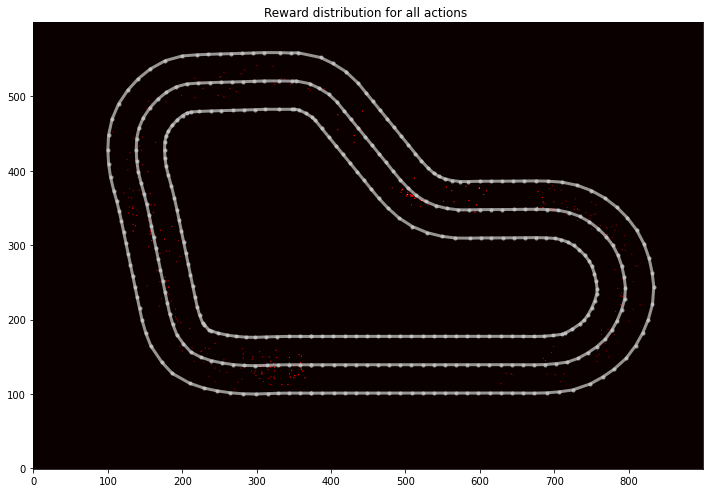

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 6: steering: 0.8, throttle: 2.7


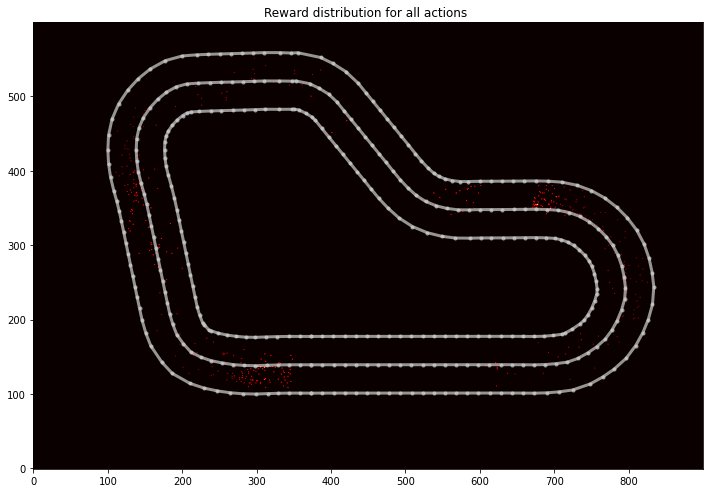

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 7: steering: 1.6, throttle: 2.3


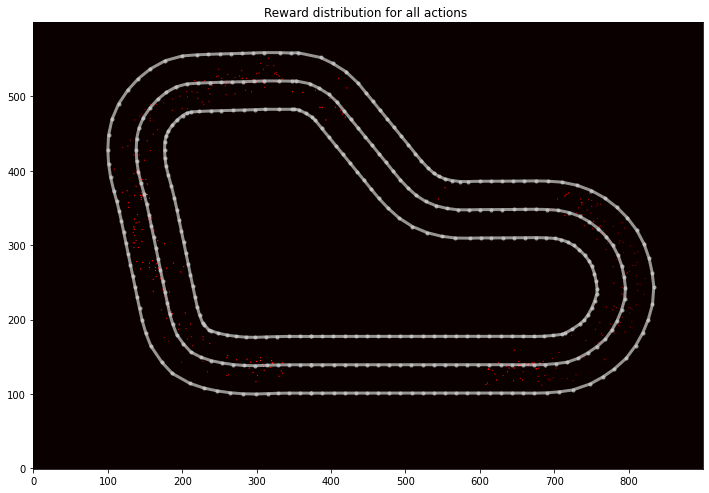

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 8: steering: 5.3, throttle: 2.0


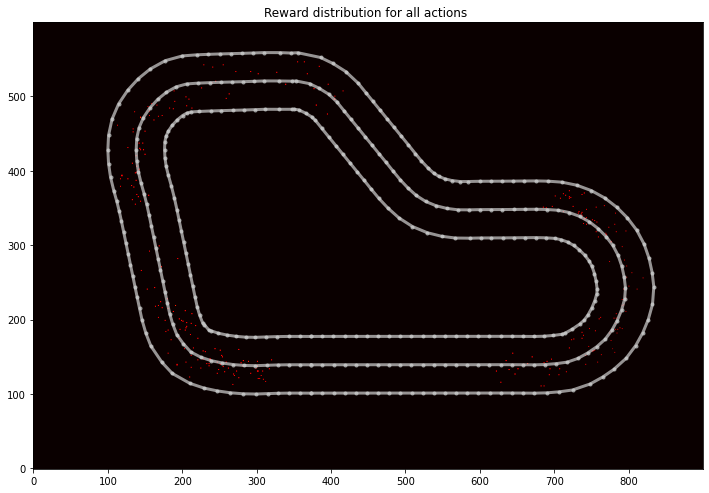

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 9: steering: 20.6, throttle: 1.7


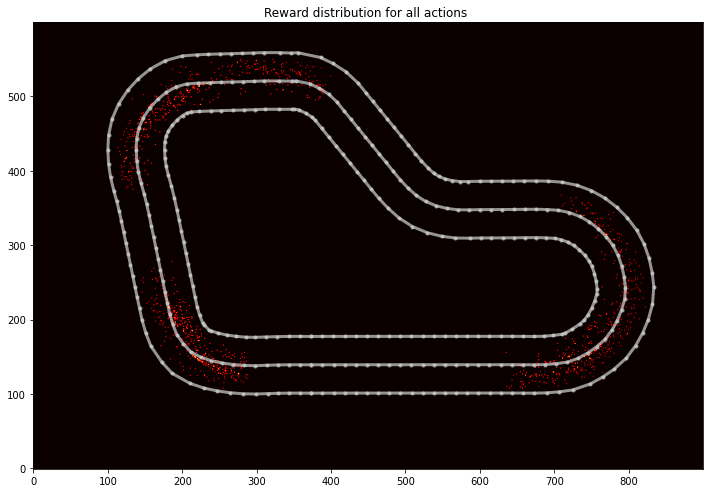

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 10: steering: 11.3, throttle: 1.7


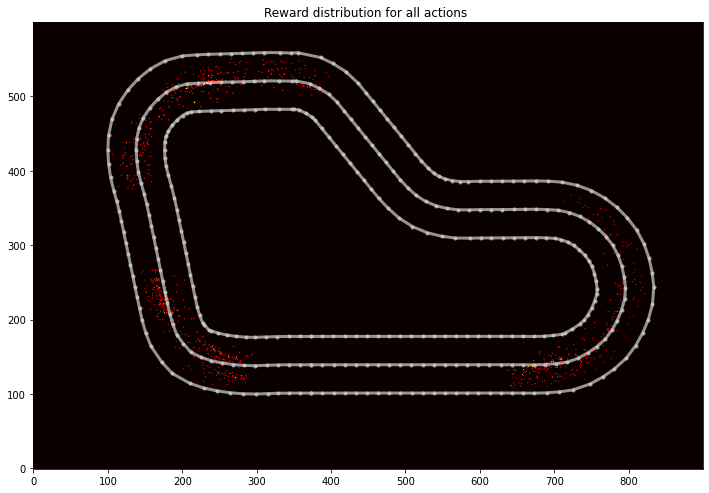

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 11: steering: -6.8, throttle: 1.8


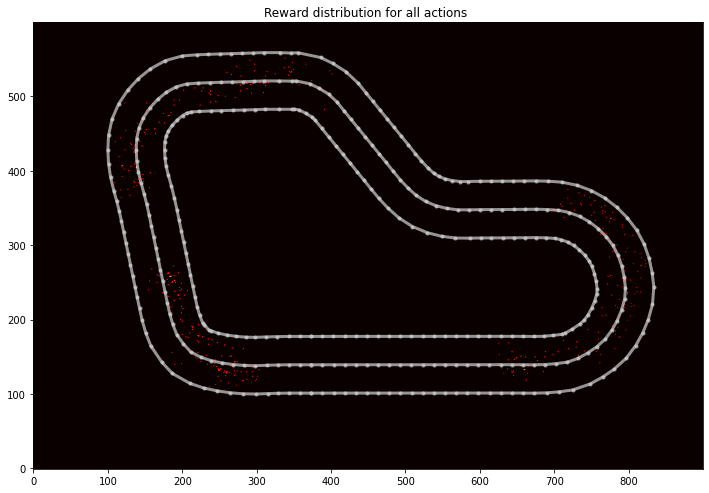

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 12: steering: -10.4, throttle: 2.7


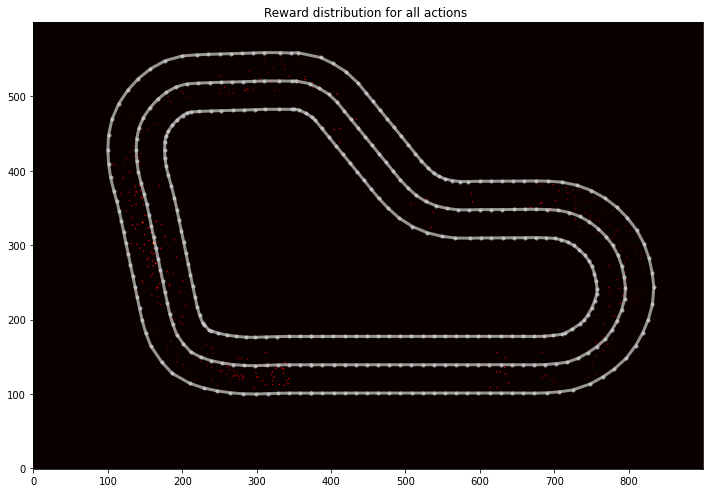

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 13: steering: 23.6, throttle: 1.4


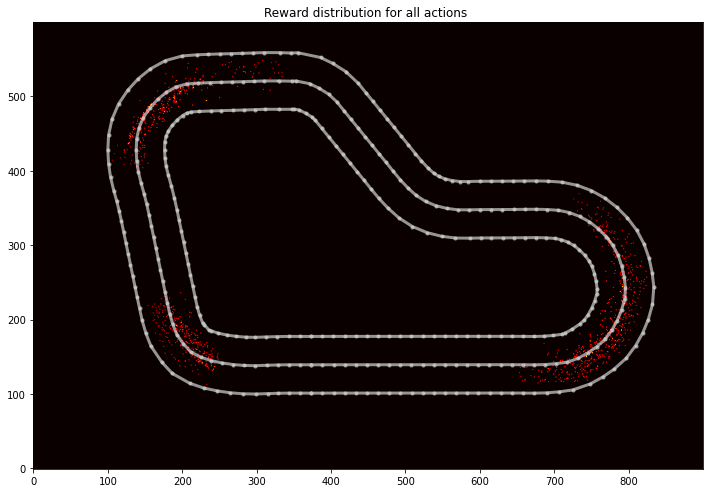

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 14: steering: 15.9, throttle: 2.2


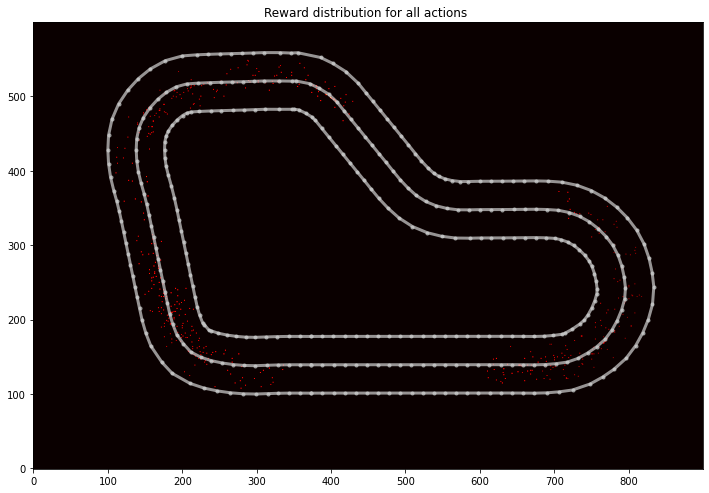

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 15: steering: -11.5, throttle: 3.3


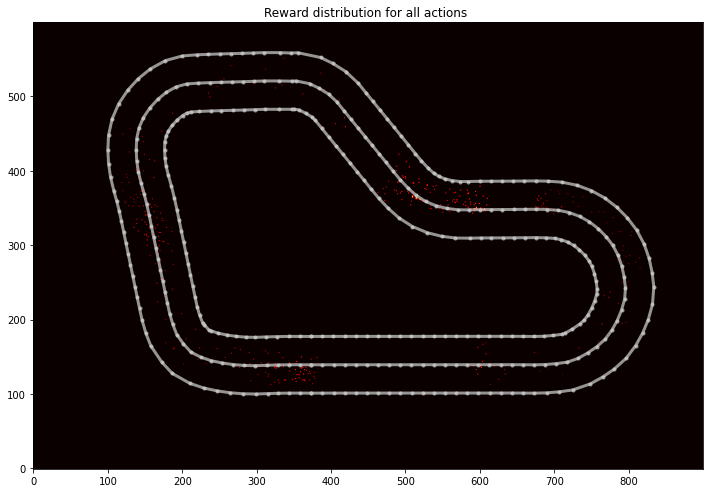

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 16: steering: 5.8, throttle: 1.4


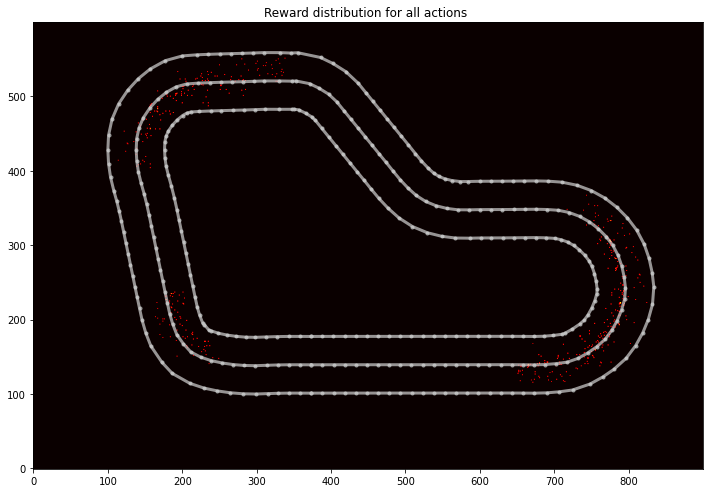

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 17: steering: -8.8, throttle: 2.1


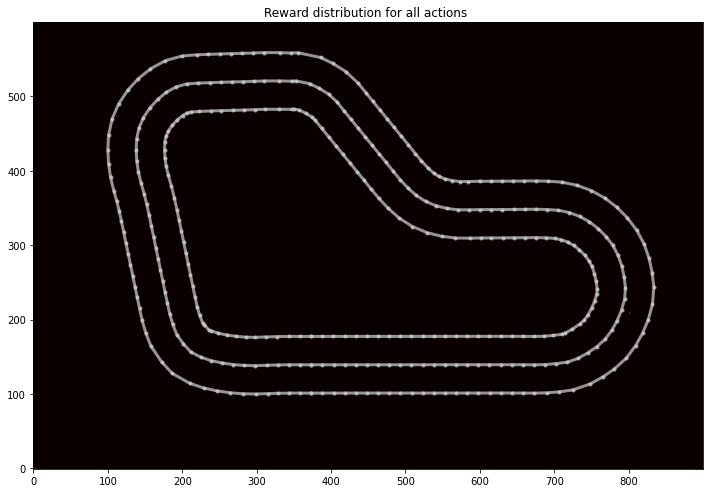

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 18: steering: 0.8, throttle: 3.3


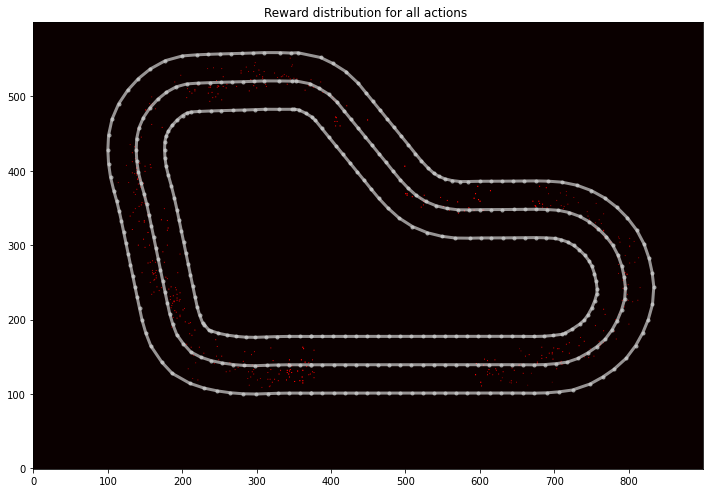

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 19: steering: 30.0, throttle: 1.3


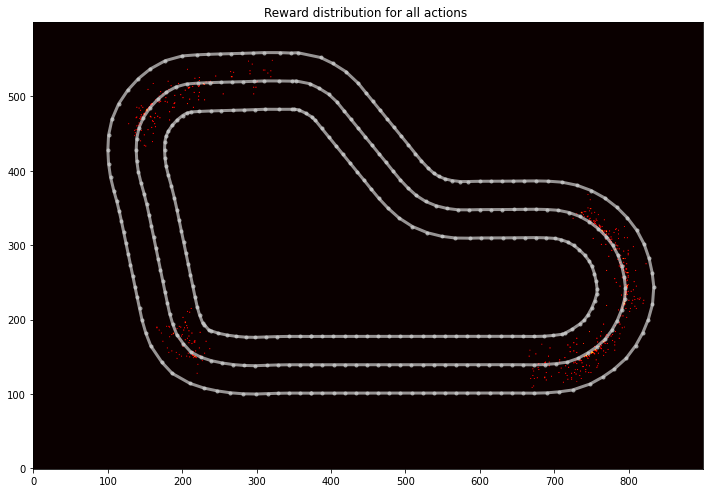

<Figure size 432x288 with 0 Axes>



 Heatmap for action with index 20: steering: -30.0, throttle: 1.3


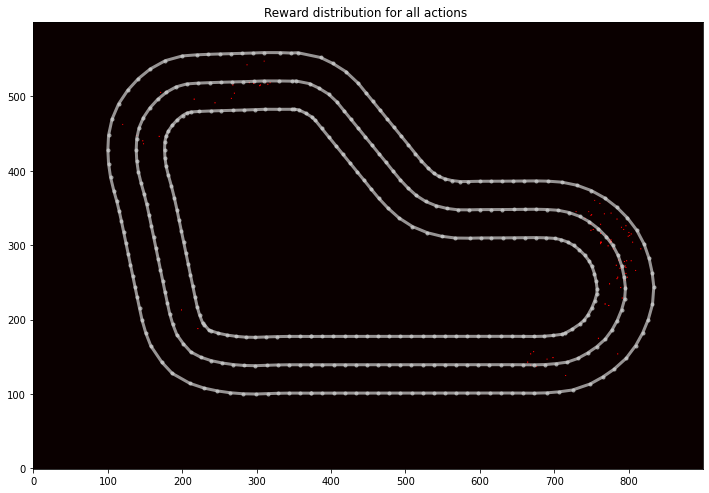

<Figure size 432x288 with 0 Axes>

In [277]:
aslNum = len(asl)
setActions = range(aslNum)     # show graphs for all Actions
# setActions = (3,4,5)       # show graphs only for index set Actions
fig = plt.figure(aslNum)
for i in setActions: 
    a = asl[i]
    print("\n\n Heatmap for action with index {}: steering: {}, throttle: {}".format(a.index, a.steer,a.throttle))
    tr_plot = pu.plot_track(df[df['action'] == a.index], track, value_field="reward") 
    plt.show()